# 4.0 Model Training
## 4.2 Feature Ablation

###### Author: Gan Yee Jing, Yeap Jie Shen, Jerome Subash A/L Joseph
###### Last Edited: 01/09/2024

### 4.2.1 Importing Libraries 

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import sys
sys.path.append(r'/home/student/RDS2S3G4_CLO2_B')

from data_stores.mongodbClient import MongoDBClient
from data_stores.redisClient import RedisClient
from data_stores.vectorArrayConverter import VectorArrayConverter

import pickle
import time
import matplotlib.pyplot as plt

### 4.3.2 Initialising Spark Session, MongoDB Client and Redis Client

In [2]:
# create spark session
spark = SparkSession.builder.appName('model training').getOrCreate()

# instantiate mongodb client
mongodb_client = MongoDBClient()

# instantiate redis client
redis_client = RedisClient(host = 'localhost', port = 6379, db = 0, start_now = True)

24/09/01 22:57:49 WARN Utils: Your hostname, Gan. resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/09/01 22:57:49 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/01 22:57:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/01 22:57:51 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Pinged your deployment. You successfully connected to MongoDB!


[sudo] password for student: 

### 4.3.3 Fetching Data from MongoDB or Redis

In [3]:
# Reading data from Redis if cache, otherwise from MongoDB with id column excluded
if redis_client.exists_key('feature_engineered_train_dataset'):
    train_list = pickle.loads(redis_client.get_value('feature_engineered_train_dataset'))
else:
    train_list = list(mongodb_client.read_many('Feature_Engineered_Dataset', 'final_train_set', {'_id': 0}))
    redis_client.set_key_value('feature_engineered_train_dataset', pickle.dumps(train_list), seconds = 5 * 60)

if redis_client.exists_key('feature_engineered_test_dataset'):
    test_list = pickle.loads(redis_client.get_value('feature_engineered_test_dataset'))
else:
    test_list = list(mongodb_client.read_many('Feature_Engineered_Dataset', 'final_test_set', {'_id': 0}))
    redis_client.set_key_value('feature_engineered_test_dataset', pickle.dumps(test_list), seconds = 5 * 60)

df_train = (
    spark.createDataFrame(train_list)
    .select(
        'category_index', 
        'author', 'url', 'datetime', 'publisher',
        '1tf_idf_content', '2tf_idf_content', '3tf_idf_content', '4tf_idf_content', '5tf_idf_content', 'tf_idf_headline',
        '1gram_word2vec_content', '2gram_word2vec_content', '3gram_word2vec_content', '4gram_word2vec_content', '5gram_word2vec_content',
        'content_token_count')
)

df_test = (
    spark.createDataFrame(test_list)
    .select(
        'category_index', 
        'author', 'url', 'datetime', 'publisher',
        '1tf_idf_content', '2tf_idf_content', '3tf_idf_content', '4tf_idf_content', '5tf_idf_content', 'tf_idf_headline',
        '1gram_word2vec_content', '2gram_word2vec_content', '3gram_word2vec_content', '4gram_word2vec_content', '5gram_word2vec_content',
        'content_token_count')
)

df_train.show()

+--------------+------+--------------------+--------------------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+----------------------+----------------------+----------------------+----------------------+-------------------+
|category_index|author|                 url|            datetime|       publisher|     1tf_idf_content|     2tf_idf_content|     3tf_idf_content|     4tf_idf_content|     5tf_idf_content|     tf_idf_headline|1gram_word2vec_content|2gram_word2vec_content|3gram_word2vec_content|4gram_word2vec_content|5gram_word2vec_content|content_token_count|
+--------------+------+--------------------+--------------------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+----------------------+----------------------+----------------------+------------

### 4.3.4 Transform Data into Suitable Format

In [4]:
# Apply the UDF to create tf_idf with sparse vector, and word2vec with dense vector
for i in range(1,6):
    df_train = (
        df_train
        .withColumn(f'{i}tf_idf_content', VectorArrayConverter.array_to_vector(df_train[f'{i}tf_idf_content']))
        .withColumn(f'{i}gram_word2vec_content', VectorArrayConverter.array_to_vector(df_train[f'{i}gram_word2vec_content']))
    )
    df_test = (
        df_test
        .withColumn(f'{i}tf_idf_content', VectorArrayConverter.array_to_vector(df_test[f'{i}tf_idf_content']))
        .withColumn(f'{i}gram_word2vec_content', VectorArrayConverter.array_to_vector(df_test[f'{i}gram_word2vec_content']))
    )

df_train = df_train.withColumn('tf_idf_headline', VectorArrayConverter.array_to_vector(df_train['tf_idf_headline']))
df_test = df_test.withColumn('tf_idf_headline', VectorArrayConverter.array_to_vector(df_test['tf_idf_headline']))

df_train.show()

+--------------+------+--------------------+--------------------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+----------------------+----------------------+----------------------+----------------------+-------------------+
|category_index|author|                 url|            datetime|       publisher|     1tf_idf_content|     2tf_idf_content|     3tf_idf_content|     4tf_idf_content|     5tf_idf_content|     tf_idf_headline|1gram_word2vec_content|2gram_word2vec_content|3gram_word2vec_content|4gram_word2vec_content|5gram_word2vec_content|content_token_count|
+--------------+------+--------------------+--------------------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+----------------------+----------------------+----------------------+------------

### 4.3.5 Defining Functions 

Available features:
1) 1tf_idf_content
2) 2tf_idf_content 
3) 3tf_idf_content 
4) 4tf_idf_content 
5) 5tf_idf_content
6) tf_idf_headline
7) 1gram_word2vec_content
8) 2gram_word2vec_content 
9) 3gram_word2vec_content
10) 4gram_word2vec_content
11) 5gram_word2vec_content
15) content_token_count

We will define a function to create different combination of feature sets

In [5]:
full_features = ['1tf_idf_content', 
                 '2tf_idf_content', 
                 '3tf_idf_content', 
                 '4tf_idf_content', 
                 '5tf_idf_content', 
                 'tf_idf_headline',
                 '1gram_word2vec_content', 
                 '2gram_word2vec_content', 
                 '3gram_word2vec_content', 
                 '4gram_word2vec_content', 
                 '5gram_word2vec_content',
                 'content_token_count']

In [33]:
# Function to create feature sets
# For Top-Down Approach, the least important features will be removed iteratively until no performance gain
# For Bottom-Up Approch, the most important features will be added iteratively until no performance gain

def create_feature_sets(approach, indexes_of_features = []):
    # To be returned
    feature_sets = []
    
    # approach = 1 (top-down), approach = 2 (bottom-up)
    if approach == 1:
        features = None # Reset
        features = full_features.copy()
        
        # To remove n features, n-1 features must be specified
        if len(indexes_of_features) != 0:
            indexes_of_features.sort(reverse=True)

            # Remove n-1 features
            for i in range(len(indexes_of_features)):
                features.pop(indexes_of_features[i])

        # Create feature sets
        for i in range(len(features)):
            set = features[:i] + features[(1+i):]
            feature_sets.append(set)
    else:
        features= [] # Reset
        fix_features = [] # Reset
        features = reduced_features.copy()
        
        if len(indexes_of_features) != 0:
            indexes_of_features.sort(reverse=False)
            
            # Get fix features
            for i in range(len(indexes_of_features)):
                fix_features.append(features[i])

            # Get remaining features
            indexes_of_features.sort(reverse=True)
            
            # Remove not specified features
            for i in range(len(indexes_of_features)):
                features.pop(indexes_of_features[i])

            # Create feature sets
            for i in range(len(features)):
                set = fix_features.copy()
                set.append(features[i])
                feature_sets.append(set)

        else:
            # Create feature sets
            for i in range(len(features)):
                feature_sets.append([features[i]])

    return feature_sets

# Function to train model
# numTrees = 30, maxDepth = 15

def train_model(feature_set):
    # assemble features into a vector
    assembler = VectorAssembler(inputCols = feature_set, outputCol='features')
    train_set = assembler.transform(df_train)
    
    # Define the Random Forest model
    random_forest = RandomForestClassifier(labelCol='category_index', featuresCol='features', seed=20, numTrees=30, maxDepth=15)

    # Train the model 
    rf_model = random_forest.fit(train_set)
    
    return rf_model

# Function to evaluate model

def evaluate_model(model, feature_set):
    # Make predictions on the test data
    assembler = VectorAssembler(inputCols = feature_set, outputCol='features')
    test_set = assembler.transform(df_test)
    predictions = model.transform(test_set)

    # Evaluate using Precision, Recall and F1 Score
    evaluator = MulticlassClassificationEvaluator(labelCol='category_index', predictionCol='prediction')
    weighted_precision = evaluator.evaluate(predictions, {evaluator.metricName: 'weightedPrecision'})
    weighted_recall = evaluator.evaluate(predictions, {evaluator.metricName: 'weightedRecall'})
    f1_score = evaluator.evaluate(predictions, {evaluator.metricName: 'f1'})

    return weighted_precision, weighted_recall, f1_score

# Function to carry out FAS 

def feature_ablation_train_model(x, indexes = []):
    # Create feature sets
    feature_sets = create_feature_sets(approach=x, indexes_of_features = indexes)
    f1_scores = []

    start_time = time.time()

    for feature_set in feature_sets:
        model = train_model(feature_set)
        precision, recall, f1_score = evaluate_model(model, feature_set)
        f1_scores.append(f1_score)

    end_time = time.time()

    return f1_scores, (end_time-start_time)/60

# Function to visualise FAS result

def visualise_feature_ablation(removed_features, f1_scores, standard_f1, approach='Removed'):
    # Visualise F1 Score
    fig, ax = plt.subplots(figsize=(12,6))
    bars = ax.barh(removed_features, f1_scores, label=removed_features, color='lightblue')

    for bar in bars:
        width = bar.get_width()
        ax.annotate(f'{width:.4f}',
                    xy = (width, bar.get_y() + bar.get_height() / 2),
                    xytext = (12, 0),
                    textcoords = 'offset points',
                    ha = 'center', va = 'bottom', fontsize = 6)

    ax.axvline(x = standard_f1, color = 'red', linestyle = '--')
    ax.set_ylabel(f'{approach} Embedding')
    ax.set_xlabel('F1 Score')
    ax.set_title(f'F1 Score with {len(removed_features)} Embeddings {approach}')

    plt.show()

### 4.3.6 Feature Ablation Study

#### 4.3.6.1 Top-Down Approach 
Start with the full model, the iteratively remove the least important feature

##### 4.3.6.1.1 With 1 Feature Removed

24/09/01 22:59:37 WARN DAGScheduler: Broadcasting large task binary with size 1255.7 KiB
24/09/01 22:59:38 WARN DAGScheduler: Broadcasting large task binary with size 1777.2 KiB
24/09/01 22:59:39 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/09/01 22:59:40 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/09/01 22:59:41 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/09/01 22:59:42 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/09/01 22:59:43 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/09/01 22:59:45 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/09/01 22:59:47 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/09/01 22:59:48 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/09/01 22:59:49 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/09/01 22:59:55 WARN DAGScheduler: Broadcastin

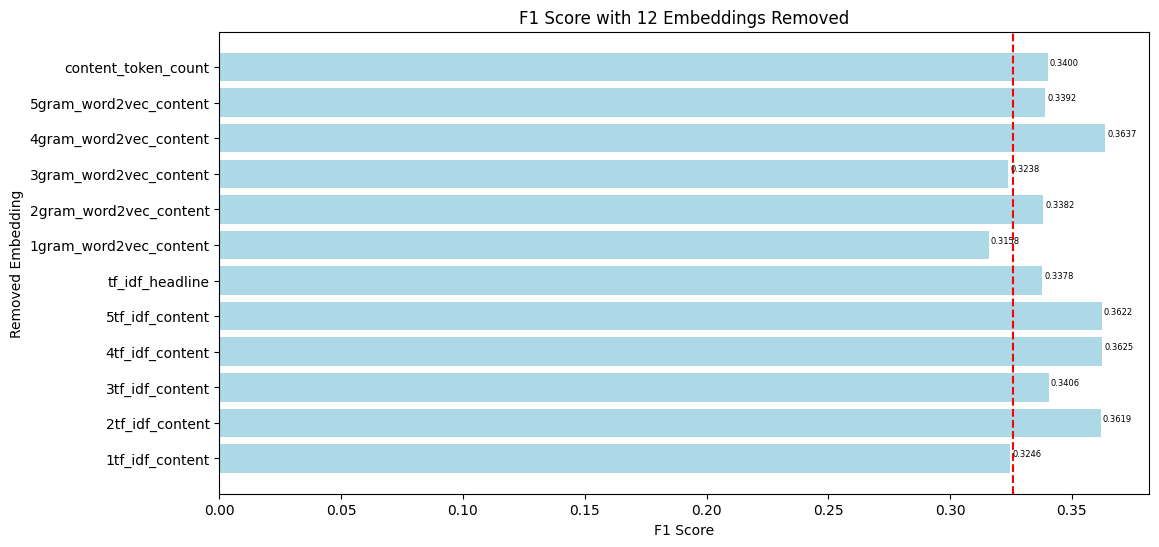

Took 3.4395771702130635 minutes to complete.


In [7]:
# Train model
remove1_f1, remove1_time_spent = feature_ablation_train_model(x=1)

# Visualise result
remove1_features = [x for x in full_features]
visualise_feature_ablation(removed_features=remove1_features, f1_scores=remove1_f1, standard_f1=0.3259)

# Print time taken
print(f"Took {remove1_time_spent} minutes to complete.")

##### 4.3.6.1.2 With 2 Feature Removed ('4gram_word2vec_content')

24/09/01 23:02:58 WARN DAGScheduler: Broadcasting large task binary with size 1215.7 KiB
24/09/01 23:02:59 WARN DAGScheduler: Broadcasting large task binary with size 1737.2 KiB
24/09/01 23:02:59 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/09/01 23:03:01 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/09/01 23:03:02 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/09/01 23:03:03 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/09/01 23:03:04 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/09/01 23:03:05 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/09/01 23:03:06 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/09/01 23:03:07 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/09/01 23:03:08 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/09/01 23:03:13 WARN DAGScheduler: Broadcastin

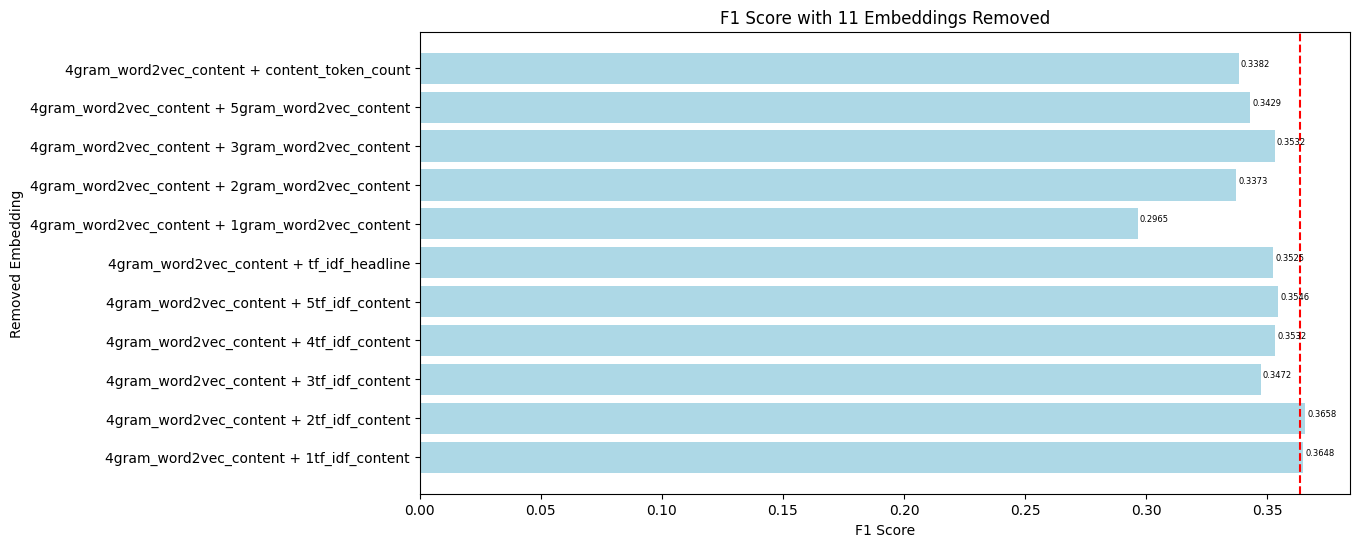

Took 2.7160560051600138 minutes to complete.


In [8]:
# Train model
remove2_f1, remove2_time_spent = feature_ablation_train_model(x=1, indexes=[9])

# Visualise result
remove2_features = ['4gram_word2vec_content + ' + x for x in full_features]
remove2_features.pop(9)
visualise_feature_ablation(removed_features=remove2_features, f1_scores=remove2_f1, standard_f1=0.3637)

# Print time taken
print(f"Took {remove2_time_spent} minutes to complete.")

##### 4.3.6.1.3 With 3 Features Removed (including '4gram_word2vec_content' and '2tf_idf_content')

24/09/01 23:08:55 WARN DAGScheduler: Broadcasting large task binary with size 1213.8 KiB
24/09/01 23:08:55 WARN DAGScheduler: Broadcasting large task binary with size 1734.2 KiB
24/09/01 23:08:56 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/09/01 23:08:57 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/09/01 23:08:57 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/09/01 23:08:58 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/09/01 23:08:59 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/09/01 23:09:00 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/09/01 23:09:01 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/09/01 23:09:01 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/09/01 23:09:02 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/09/01 23:09:06 WARN DAGScheduler: Broadcastin

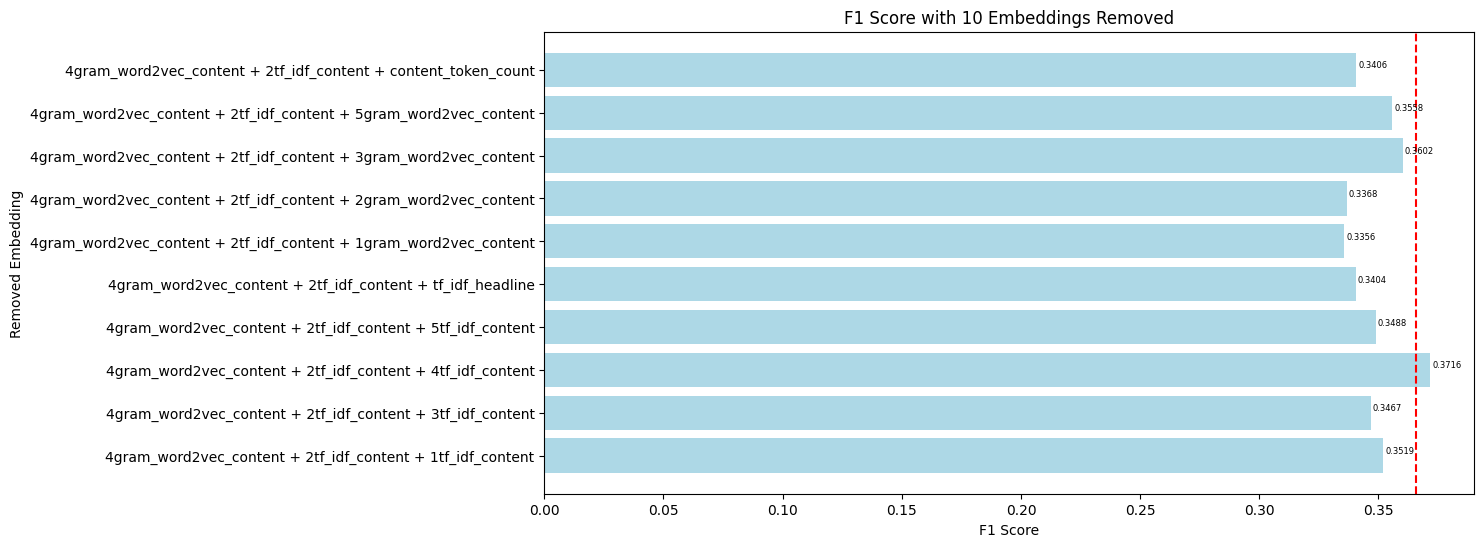

Took 2.019924747943878 minutes to complete.


In [10]:
# Train model
remove3_f1, remove3_time_spent = feature_ablation_train_model(x=1, indexes=[9, 1])

# Visualise result
remove3_features = ['4gram_word2vec_content + 2tf_idf_content + ' + x for x in full_features]
remove3_features.pop(9)
remove3_features.pop(1)
visualise_feature_ablation(removed_features=remove3_features, f1_scores=remove3_f1, standard_f1=0.3658)

# Print time taken
print(f"Took {remove3_time_spent} minutes to complete.")

##### 4.3.6.1.4 With 4 Features Removed (including '4gram_word2vec_content', '2tf_idf_content', '4tf_idf_content')

24/09/01 23:11:21 WARN DAGScheduler: Broadcasting large task binary with size 1185.4 KiB
24/09/01 23:11:22 WARN DAGScheduler: Broadcasting large task binary with size 1717.4 KiB
24/09/01 23:11:22 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/09/01 23:11:23 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/09/01 23:11:24 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/09/01 23:11:24 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/09/01 23:11:25 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/09/01 23:11:26 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
24/09/01 23:11:27 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/09/01 23:11:27 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/09/01 23:11:28 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/09/01 23:11:31 WARN DAGScheduler: Broadcastin

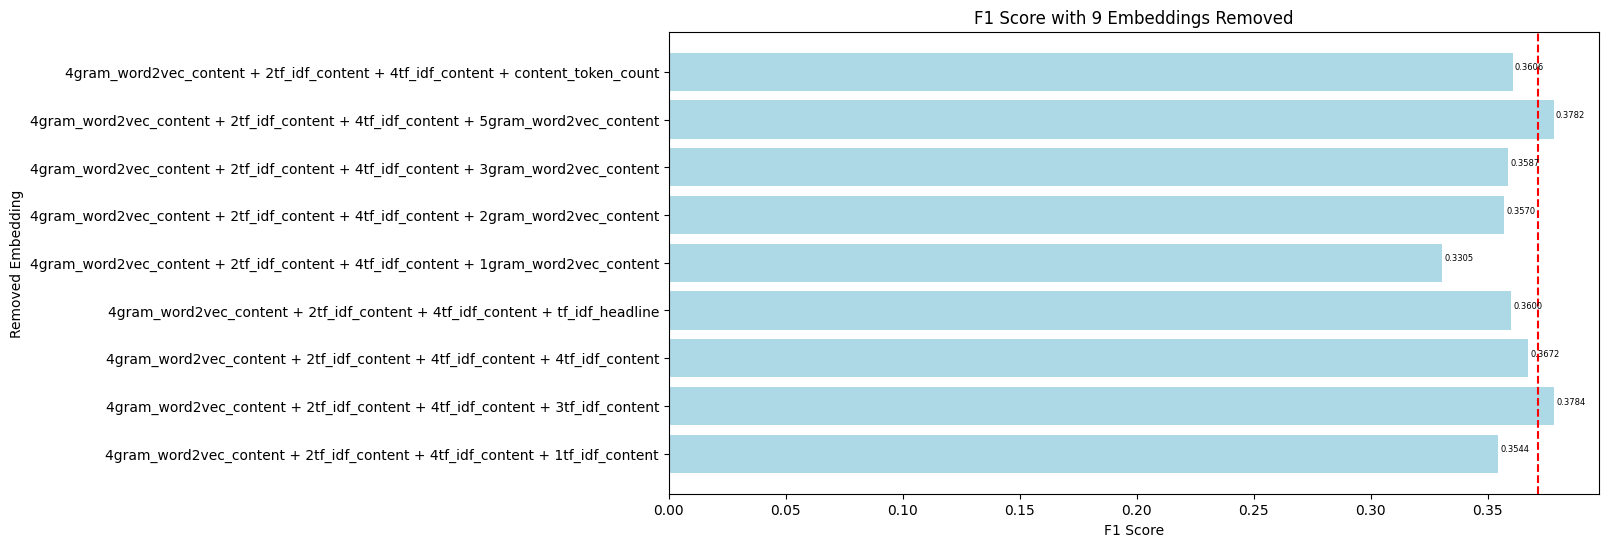

Took 1.8285746335983277 minutes to complete.


In [11]:
# Train model
remove4_f1, remove4_time_spent = feature_ablation_train_model(x=1, indexes=[9, 1, 3])

# Visualise result
remove4_features = ['4gram_word2vec_content + 2tf_idf_content + 4tf_idf_content + ' + x for x in full_features]
remove4_features.pop(9)
remove4_features.pop(1)
remove4_features.pop(3)
visualise_feature_ablation(removed_features=remove4_features, f1_scores=remove4_f1, standard_f1=0.3716)

# Print time taken
print(f"Took {remove4_time_spent} minutes to complete.")

##### 4.3.6.1.5 With 5 Features Removed (including '4gram_word2vec_content', '2tf_idf_content', '4tf_idf_content', '3tf_idf_content')

24/09/01 23:13:39 WARN DAGScheduler: Broadcasting large task binary with size 1158.0 KiB
24/09/01 23:13:40 WARN DAGScheduler: Broadcasting large task binary with size 1687.4 KiB
24/09/01 23:13:40 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/09/01 23:13:41 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/09/01 23:13:42 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/09/01 23:13:42 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/09/01 23:13:43 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/09/01 23:13:44 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/09/01 23:13:45 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/09/01 23:13:45 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/09/01 23:13:46 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/09/01 23:13:50 WARN DAGScheduler: Broadcastin

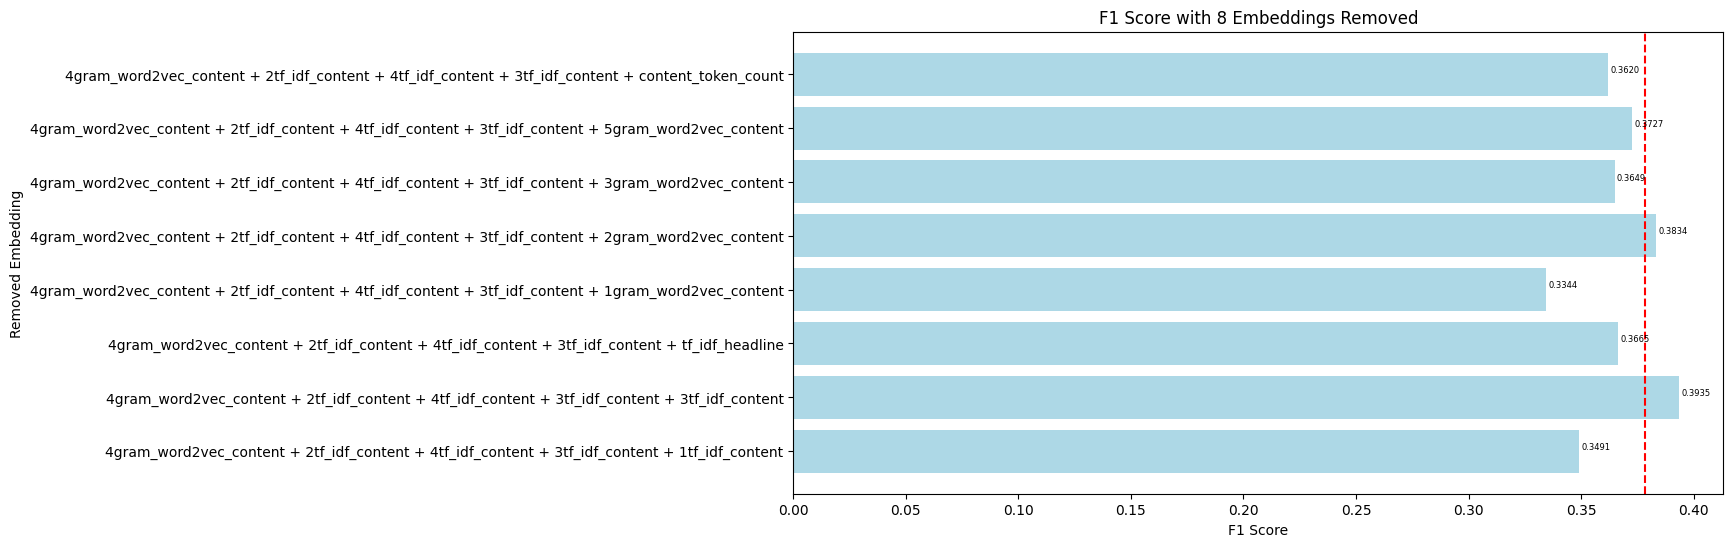

Took 1.6717437386512757 minutes to complete.


In [12]:
# Train model
remove5_f1, remove5_time_spent = feature_ablation_train_model(x=1, indexes=[9, 1, 3, 2])

# Visualise result
remove5_features = ['4gram_word2vec_content + 2tf_idf_content + 4tf_idf_content + 3tf_idf_content + ' + x for x in full_features]
remove5_features.pop(9)
remove5_features.pop(1)
remove5_features.pop(3)
remove5_features.pop(2)
visualise_feature_ablation(removed_features=remove5_features, f1_scores=remove5_f1, standard_f1=0.3784)

# Print time taken
print(f"Took {remove5_time_spent} minutes to complete.")

##### 4.3.6.1.6 With 6 Features Removed (including '4gram_word2vec_content', '2tf_idf_content', '4tf_idf_content', '3tf_idf_content', '5tf_idf_content')

24/09/01 23:15:36 WARN DAGScheduler: Broadcasting large task binary with size 1173.0 KiB
24/09/01 23:15:37 WARN DAGScheduler: Broadcasting large task binary with size 1691.2 KiB
24/09/01 23:15:37 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/09/01 23:15:38 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/09/01 23:15:38 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/09/01 23:15:39 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/09/01 23:15:40 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
24/09/01 23:15:40 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
24/09/01 23:15:41 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/09/01 23:15:42 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/09/01 23:15:43 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/09/01 23:15:47 WARN DAGScheduler: Broadcastin

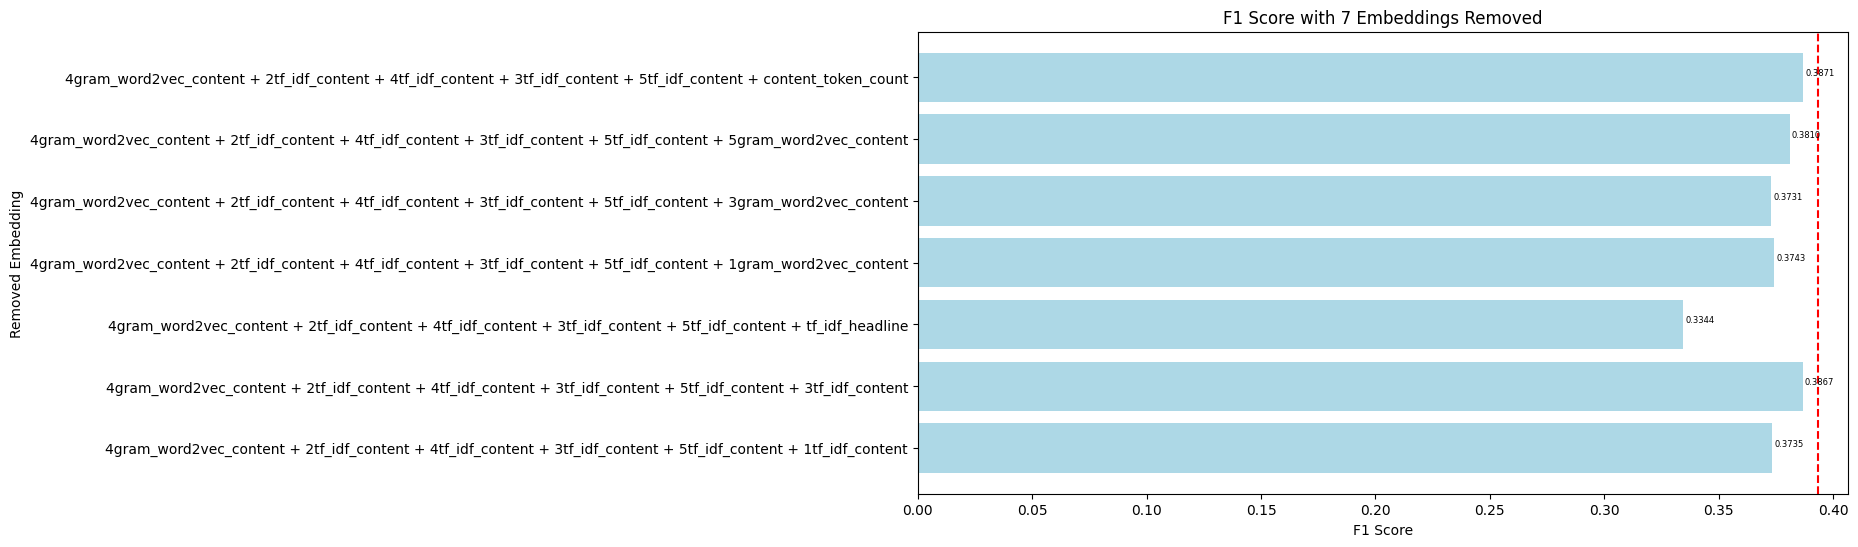

Took 1.3553964138031005 minutes to complete.


In [13]:
# Train model
remove6_f1, remove6_time_spent = feature_ablation_train_model(x=1, indexes=[9, 1, 3, 2, 4])

# Visualise result
remove6_features = ['4gram_word2vec_content + 2tf_idf_content + 4tf_idf_content + 3tf_idf_content + 5tf_idf_content + ' + x for x in full_features]
remove6_features.pop(9)
remove6_features.pop(1)
remove6_features.pop(3)
remove6_features.pop(2)
remove6_features.pop(4)
visualise_feature_ablation(removed_features=remove6_features, f1_scores=remove6_f1, standard_f1=0.3935)

# Print time taken
print(f"Took {remove6_time_spent} minutes to complete.")

__Remarks__: Since no performance gained after further removing the sixth feature, hence the top-down approach stops here

#### 4.3.6.2 Bottom-Up Approach 
Based on the top-down approach, we already identified 5 least important features:
1) '4gram_word2vec_content'
2) '2tf_idf_content'
3) '4tf_idf_content'
4) '3tf_idf_content'
5) '5tf_idf_content'

In this section, we will consider a bottom-up approach with the remaining 7 features

##### 4.3.6.2.1 With 1 Feature

In [29]:
reduced_features = ['1tf_idf_content', 
            'tf_idf_headline',
            '1gram_word2vec_content', 
            '2gram_word2vec_content', 
            '3gram_word2vec_content', 
            '5gram_word2vec_content',
            'content_token_count']

24/09/01 23:45:02 WARN DAGScheduler: Broadcasting large task binary with size 1256.4 KiB
24/09/01 23:45:02 WARN DAGScheduler: Broadcasting large task binary with size 1900.9 KiB
24/09/01 23:45:03 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/09/01 23:45:04 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/09/01 23:45:04 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/09/01 23:45:05 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/09/01 23:45:06 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/09/01 23:45:06 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
24/09/01 23:45:07 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/09/01 23:45:08 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/09/01 23:45:08 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/09/01 23:45:11 WARN DAGScheduler: Broadcastin

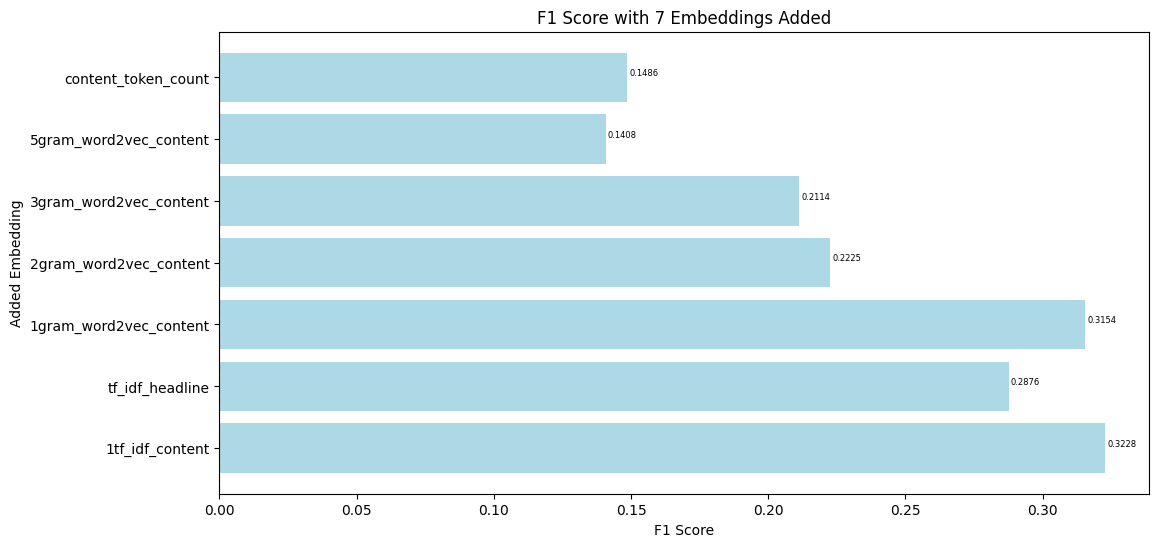

Took 0.9788495143254597 minutes to complete.


In [34]:
# Train model
add1_f1, add1_time_spent = feature_ablation_train_model(x=2, indexes=[])

# Visualise result
add1_features = [x for x in reduced_features]
visualise_feature_ablation(removed_features=add1_features, f1_scores=add1_f1, standard_f1=0, approach='Added')

# Print time taken
print(f"Took {add1_time_spent} minutes to complete.")

##### 4.3.6.2.2 With 2 Features (including '1tf_idf_content')

24/09/01 23:50:45 WARN DAGScheduler: Broadcasting large task binary with size 1242.0 KiB
24/09/01 23:50:46 WARN DAGScheduler: Broadcasting large task binary with size 1855.5 KiB
24/09/01 23:50:46 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/09/01 23:50:47 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/09/01 23:50:47 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/09/01 23:50:49 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/09/01 23:50:49 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/09/01 23:50:50 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
24/09/01 23:50:51 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/09/01 23:50:52 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/09/01 23:50:52 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/09/01 23:50:55 WARN DAGScheduler: Broadcastin

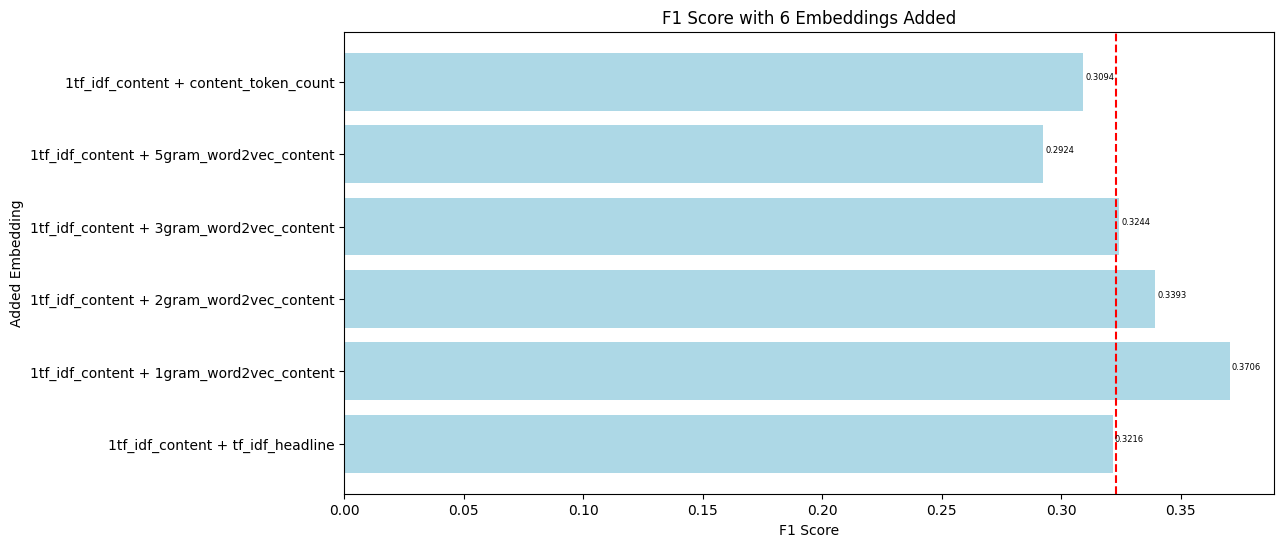

Took 1.1069857041041056 minutes to complete.


In [36]:
# Train model
add2_f1, add2_time_spent = feature_ablation_train_model(x=2, indexes=[0])

# Visualise result
add2_features = ['1tf_idf_content + ' + x for x in reduced_features]
add2_features.pop(0)
visualise_feature_ablation(removed_features=add2_features, f1_scores=add2_f1, standard_f1=0.3228, approach='Added')

# Print time taken
print(f"Took {add2_time_spent} minutes to complete.")

##### 4.3.6.2.3 With 3 Features (including '1tf_idf_content', '1gram_word2vec_content')

24/09/01 23:53:04 WARN DAGScheduler: Broadcasting large task binary with size 1252.0 KiB
24/09/01 23:53:04 WARN DAGScheduler: Broadcasting large task binary with size 1847.9 KiB
24/09/01 23:53:04 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/09/01 23:53:05 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/09/01 23:53:05 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/09/01 23:53:06 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/09/01 23:53:07 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/09/01 23:53:08 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
24/09/01 23:53:08 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/09/01 23:53:09 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/09/01 23:53:10 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/09/01 23:53:13 WARN DAGScheduler: Broadcastin

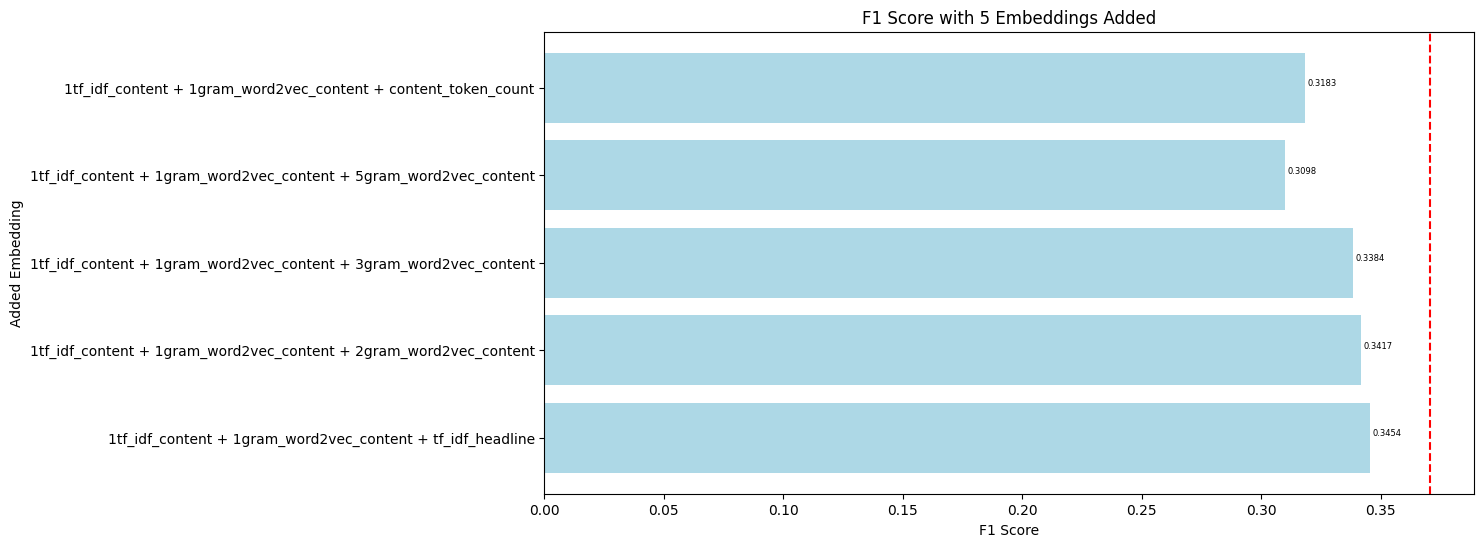

Took 0.8781323194503784 minutes to complete.


In [37]:
# Train model
add3_f1, add3_time_spent = feature_ablation_train_model(x=2, indexes=[0, 2])

# Visualise result
add3_features = ['1tf_idf_content + 1gram_word2vec_content + ' + x for x in reduced_features]
add3_features.pop(2)
add3_features.pop(0)
visualise_feature_ablation(removed_features=add3_features, f1_scores=add3_f1, standard_f1=0.3706, approach='Added')

# Print time taken
print(f"Took {add3_time_spent} minutes to complete.")

__Conclusion__: The model should only include '1tf_idf_content' and '1gram_word2vec_content'. The highest F1-Score yield is 0.3706

### 4.3.7 Train and Save the Best Model

Parameters:
1) numTrees = 30
2) maxDepth = 15

Feature Set:
1) 1tf_idf_content
2) 1gram_word2vec_content

In [38]:
# Train model
final_feature_set = ['1tf_idf_content', '1gram_word2vec_content']
final_model = train_model(feature_set=final_feature_set)

# Save model
final_model.save(r'../model/best_model')

24/09/02 00:01:11 WARN DAGScheduler: Broadcasting large task binary with size 1139.5 KiB
24/09/02 00:01:11 WARN DAGScheduler: Broadcasting large task binary with size 1666.1 KiB
24/09/02 00:01:11 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/09/02 00:01:12 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/09/02 00:01:13 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/09/02 00:01:13 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/09/02 00:01:14 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/09/02 00:01:14 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


In [39]:
redis_client.stop_service()
spark.stop()

[sudo] password for student: 